# Import Libraries

In [1]:
import json
import numpy as np
import pandas as pd
import spacy
import sklearn

from nltk.corpus import stopwords
 
from gensim.corpora import Dictionary, bleicorpus

import gensim
from gensim.matutils import hellinger
from gensim.utils import simple_preprocess
from gensim.models import ldaseqmodel,CoherenceModel

import pprint as pprint

import re

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud

import os
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [34]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
import matplotlib.pyplot as plt

# Data Collection

In [3]:
def cvss_severity(row):
    if any(row['impact']):
        for key in row['impact']:
            if key=="baseMetricV3":
                return row['impact']['baseMetricV3']['cvssV3']['baseSeverity'] 
            else:
                return 'V2'
    else:
        return np.nan 

In [4]:
def cvss_score(row):
    if any(row['impact']):
        for key in row['impact']:
            if key=="baseMetricV3":
                return row['impact']['baseMetricV3']['cvssV3']['baseScore']
            else:
                return '999'
    else:
        return np.nan

In [5]:
def extract_info(file_name):
    main_data = pd.DataFrame(columns = ['ID','Assigner','Description','Severity','Score','Timestamp','Date'])
    
    for i in range(len(file_name)):
        file = dir_name+file_name[i]
    
        df = pd.read_json(file)
        
        final_data = pd.DataFrame(columns = ['ID','Description','Severity','Score','Timestamp'])
    
        #Unique CVE ID 
        final_data['ID']=df['CVE_Items'].apply(lambda row:row['cve']['CVE_data_meta']['ID'])
        
        #Assigner 
        final_data['Assigner']=df['CVE_Items'].apply(lambda row:row['cve']['CVE_data_meta']['ASSIGNER'])
    
        #Vulenrability Description
        final_data['Description']=df['CVE_Items'].apply(lambda row:row['cve']['description']['description_data'][0]['value'])
        
        #Severity
        final_data['Severity'] = df['CVE_Items'].apply(cvss_severity)
        
        #Score
        final_data['Score'] = df['CVE_Items'].apply(cvss_score)
        
        #Latest Publish date
        final_data['Timestamp'] = df['CVE_Items'].apply(lambda row:row['publishedDate'])
    
        final_data['Date'] = final_data['Timestamp'].apply(lambda row: row[0:10])
        
        final_data['Year'] = final_data['Date'].apply(lambda row: row[0:4])
        
        main_data = main_data.append(final_data, ignore_index = True)
    
    return main_data

In [6]:
dir_name = "C:/Arundhati/Dissertation/Data/"
file_list = os.listdir(dir_name)

In [7]:
data_frame = extract_info(file_list)

In [8]:
data_frame.head()

,ID,Assigner,Description,Severity,Score,Timestamp,Date,Year
0,CVE-2019-0001,sirt@juniper.net,Receipt of a malformed packet on MX Series dev...,HIGH,7.5,2019-01-15T21:29Z,2019-01-15,2019
1,CVE-2019-0002,sirt@juniper.net,"On EX2300 and EX3400 series, stateless firewal...",CRITICAL,9.8,2019-01-15T21:29Z,2019-01-15,2019
2,CVE-2019-0003,sirt@juniper.net,When a specific BGP flowspec configuration is ...,MEDIUM,5.9,2019-01-15T21:29Z,2019-01-15,2019
3,CVE-2019-0004,sirt@juniper.net,"On Juniper ATP, the API key and the device key...",MEDIUM,5.5,2019-01-15T21:29Z,2019-01-15,2019
4,CVE-2019-0005,sirt@juniper.net,"On EX2300, EX3400, EX4600, QFX3K and QFX5K ser...",MEDIUM,5.3,2019-01-15T21:29Z,2019-01-15,2019


# Data Cleaning

In [9]:
print(data_frame.shape)
data_frame.isna().sum()

(66957, 8)


ID                0
Assigner          0
Description       0
Severity       3271
Score          3271
Timestamp         0
Date              0
Year              0
dtype: int64

In [10]:
data_frame.drop(data_frame[data_frame['Severity'].isna()].index,inplace=True)

In [11]:
data_frame.shape

(63686, 8)

In [12]:
# Removes rejected and disputed rows 
pattern = r'^[**]'
data_frame['is_rejected'] = data_frame['Description'].apply(lambda x: 1 if re.match(pattern,x) else 0)

rejected_rows = data_frame['is_rejected'].sum()
if rejected_rows!=0:
    data_frame.drop(data_frame[data_frame['is_rejected']==True].index,inplace=True)
    print("{} rows deleted".format(rejected_rows))
else:
    print("Rejected & Disputed rows already dropped")

402 rows deleted


In [13]:
#Rows with the V2 CVSS scoring
data_frame['Severity'].value_counts()

HIGH        26593
MEDIUM      26007
CRITICAL     9372
LOW          1312
Name: Severity, dtype: int64

In [14]:
data_frame['Score'].value_counts()

9.8    7888
7.8    7516
7.5    7503
8.8    6287
6.5    4613
       ... 
2.0       4
3.0       3
1.8       3
2.1       3
1.9       1
Name: Score, Length: 80, dtype: int64

In [15]:
data_frame.drop(data_frame[data_frame['Severity'] == 'V2'].index, inplace = True)

In [16]:
data_frame.shape

(63284, 9)

## Sort DataFrame for Dynamic Topic Model

In [17]:
sorted_df = data_frame.sort_values('Timestamp').reset_index(drop=True)
sorted_df.head()

,ID,Assigner,Description,Severity,Score,Timestamp,Date,Year,is_rejected
0,CVE-2019-3494,cve@mitre.org,Simply-Blog through 2019-01-01 has SQL Injecti...,HIGH,7.5,2019-01-01T15:29Z,2019-01-01,2019,0
1,CVE-2019-3500,cve@mitre.org,"aria2c in aria2 1.33.1, when --log is used, ca...",HIGH,7.8,2019-01-02T07:29Z,2019-01-02,2019,0
2,CVE-2019-3501,cve@mitre.org,The OUGC Awards plugin before 1.8.19 for MyBB ...,MEDIUM,4.8,2019-01-02T13:29Z,2019-01-02,2019,0
3,CVE-2019-3572,cve@mitre.org,An issue was discovered in libming 0.4.8. Ther...,MEDIUM,6.5,2019-01-02T15:29Z,2019-01-02,2019,0
4,CVE-2019-3573,cve@mitre.org,"In libsixel v1.8.2, there is an infinite loop ...",MEDIUM,5.5,2019-01-02T15:29Z,2019-01-02,2019,0


In [18]:
sorted_df['Year'].unique()

array(['2019', '2020', '2021', '2022'], dtype=object)

# Data Preprocessing Functions

## Tokenize Words

In [19]:
def tokenize_words(df):
    df['tokens'] = df['Description'].apply(lambda row:gensim.utils.simple_preprocess(str(row), deacc=True))
    
    #Remove repeated words
    df['tokens'] = df['tokens']
    return df

## Remove Stopwords

In [20]:
stop_words_list = stopwords.words('english')
stop_words_list.extend(['via','aka','http'])

In [21]:
def remove_stopwords(df):
    df['no_stopwords'] = df['tokens'].apply(lambda i: [j for j in i if j not in stop_words_list])
    return df

## Bag of Words

In [22]:
def bag_of_words(df):
    words_list = df.no_stopwords.values.tolist()
    return words_list

## N-gram

In [23]:
def n_grams(words):
    bigram = gensim.models.Phrases(words, min_count=5, threshold=90) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[words], threshold=100)
    
    
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    n_gram_words = [bigram_mod[doc] for doc in words]
    n_gram_words = [trigram_mod[bigram_mod[doc]] for doc in words]
    
    return n_gram_words

## Lemmatization

In [24]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [25]:
pos_list = ['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize(words):
    texts_out = []
    for sent in words:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in pos_list])
    return texts_out

# Split Train and Test Data

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x_train ,x_test = train_test_split(data_frame,test_size=0.7,random_state=101) 

In [28]:
x_train.head()

,ID,Assigner,Description,Severity,Score,Timestamp,Date,Year,is_rejected
65268,CVE-2022-31287,cve@mitre.org,An issue was discovered in Bento4 v1.2. There ...,MEDIUM,5.5,2022-06-10T18:15Z,2022-06-10,2022,0
27426,CVE-2020-26701,cve@mitre.org,Cross-site scripting (XSS) vulnerability in Da...,MEDIUM,5.4,2020-11-17T18:15Z,2020-11-17,2020,0
29200,CVE-2020-29551,cve@mitre.org,An issue was discovered in URVE Build 24.03.20...,CRITICAL,9.1,2020-12-23T16:15Z,2020-12-23,2020,0
42206,CVE-2021-25245,security@trendmicro.com,An improper access control vulnerability in Wo...,MEDIUM,5.3,2021-02-04T20:15Z,2021-02-04,2021,0
20998,CVE-2020-13860,cve@mitre.org,An issue was discovered on Mofi Network MOFI45...,HIGH,7.5,2021-02-01T02:15Z,2021-02-01,2021,0


# LDA -Training Set

## Data Preprocessing

In [29]:
#Tokenize Words
processed_df = tokenize_words(x_train)

#Remove Stopwords
no_stop_df = remove_stopwords(processed_df)

#Create Bag of Words
words_list = bag_of_words(no_stop_df)

#n-gram words
n_gram_words = n_grams(words_list)

#Lemmatize
lemmatized_words = lemmatize(n_gram_words)

<ipython-input-19-4bede7c3d975>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['Description'].apply(lambda row:gensim.utils.simple_preprocess(str(row), deacc=True))
<ipython-input-19-4bede7c3d975>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['tokens']


In [30]:
lemmatized_words[0][0:10]

['issue', 'discover', 'allocation', 'size', 'request', 'error']

## Create Corpus

In [31]:
#Dictionary
id2word = Dictionary(lemmatized_words)

# Term Document Frequency
corpus = [id2word.doc2bow(word) for word in lemmatized_words]

## Word Cloud of Corpus

In [32]:
cloud_words = " ".join(" ".join(x) for x in lemmatized_words)

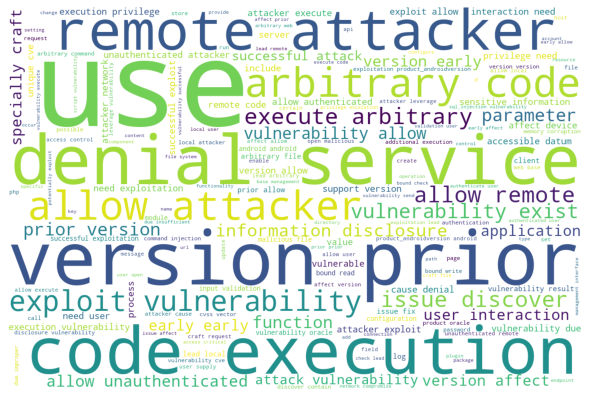

In [35]:
#Normal Word Cloud
wordcloud = WordCloud(width = 1200, height = 800,
                background_color ='white',
                min_font_size = 10).generate(cloud_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [36]:
from PIL import Image
mask = np.array(Image.open("C:/Arundhati/Dissertation/Report Images/Danger logo.png"))

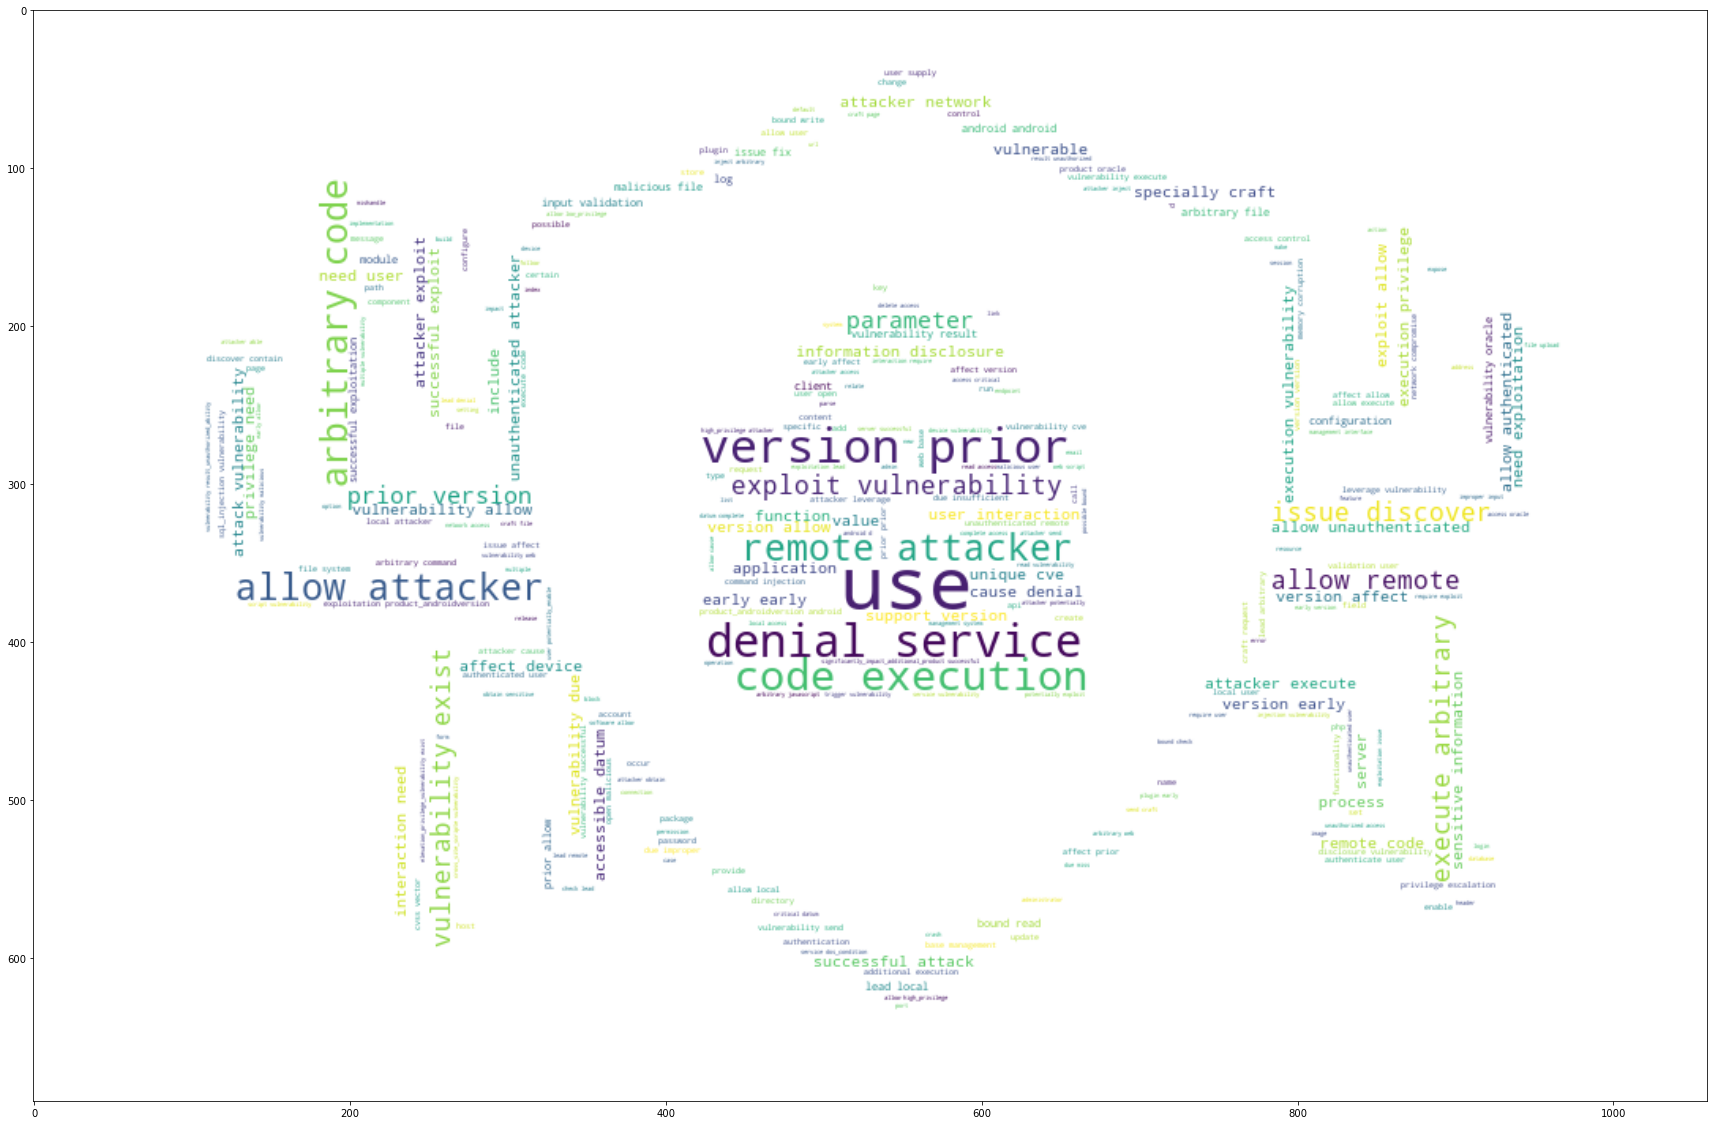

In [37]:
wc = WordCloud(font_path=None,
               mask=mask, background_color="white",
               max_words=2000,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0])
wc.generate(cloud_words)
plt.figure( figsize=(30,30) )
plt.imshow(wc, interpolation="bilinear")
#plt.axis('off')
plt.show()

# LDA Topic Model

## Determining best parameters

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

In [40]:
num_topics = np.arange(10,30)
num_keywords = 15

LDA_models = {}
LDA_topics = {}

for i in num_topics:
    LDA_models[i] = LdaModel(corpus=corpus,
                             id2word=id2word,
                             num_topics=i,
                             update_every=1,
                             passes=50,
                             alpha='auto',
                             random_state=101)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [41]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [42]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]


In [43]:
def coherences():
    coherence_list=[]
    for i in num_topics[:-1]:
        coh = CoherenceModel(model=LDA_models[i], 
                            texts=lemmatized_words, dictionary=id2word,
                             coherence='u_mass').get_coherence()
        print(coh)
        coherence_list.append(coh)
    return coherence_list

In [44]:
coherences = coherences()

-2.6006111065639574
-2.559671500329842
-3.101474164319265
-3.0830371621184645
-2.8679145071113177
-2.9053698351688406
-2.866540939849278
-2.7240346583980313
-3.3190165066155326
-3.9881939512592997
-3.710178705385303
-4.14938009749838
-4.063272271351239
-4.26575007258705
-3.811198150836199
-3.9383942253962374
-3.904496080191085
-4.513768618684895
-4.312569595852573


In [45]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

In [46]:
ideal_topic_num,ideal_topic_num_index

(11, 1)

In [176]:
perplexity = [LDA_models[i].log_perplexity(corpus) for i in num_topics[:-1]]

In [178]:
perplexity

[-6.864618918254986,
 -7.028720202297565,
 -7.254410469002297,
 -7.432912511653123,
 -7.548381751106277,
 -7.649595684934975,
 -7.705900927005223,
 -7.78806057295328,
 -7.858528967105249,
 -7.9279028112669385,
 -7.975185095430695,
 -8.068977885939235,
 -8.116443035132974,
 -8.207656114761097,
 -8.271963170312281,
 -8.353342105432795,
 -8.43171516573999,
 -8.50298291887433,
 -8.57441333930601]

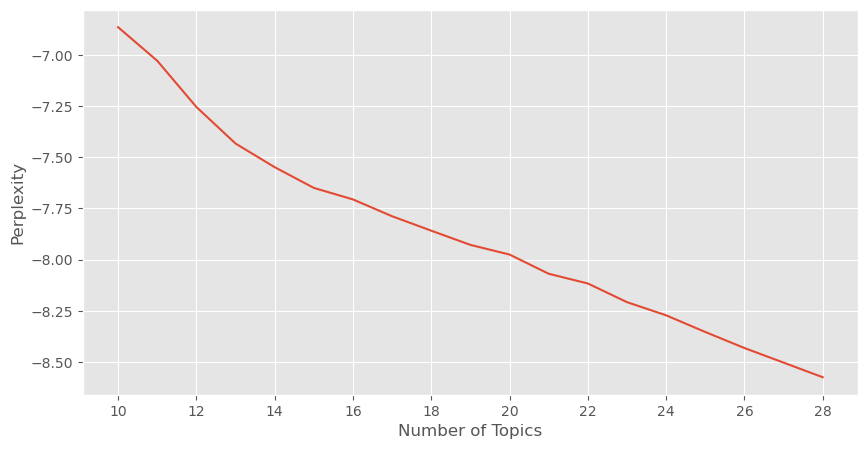

In [177]:
plt.figure(figsize=(10,5))
ax=sns.lineplot(x=list(num_topics)[:-1] , y=perplexity)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Perplexity', fontsize=12)
ax.set_xlabel('Number of Topics', fontsize=12)

plt.show()

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')
#ax = sns.lineplot(x=num_topics[:-1], y=perplexity, label='Perplexity')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')
plt.annotate(ideal_topic_num, 
             (ideal_topic_num,coh_sta_max),ha='left')

y_min = -10
y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
                  
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [139]:
from matplotlib.ticker import MaxNLocator

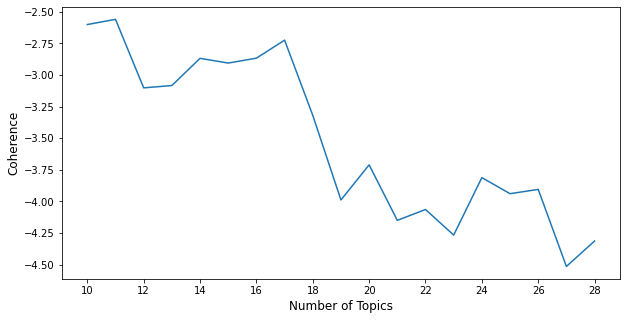

In [160]:
plt.figure(figsize=(10,5))
ax=sns.lineplot(x=list(num_topics)[:-1] , y=coherences)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Coherence', fontsize=12)
ax.set_xlabel('Number of Topics', fontsize=12)

plt.show()

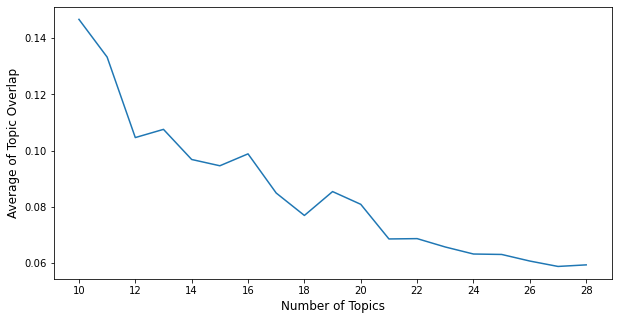

In [162]:
plt.figure(figsize=(10,5))
ax=sns.lineplot(x=list(num_topics)[:-1] , y=mean_stabilities)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Average of Topic Overlap', fontsize=12)
ax.set_xlabel('Number of Topics', fontsize=12)

plt.show()

## Visualize the best model

In [61]:
import pyLDAvis
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(LDA_models[ideal_topic_num], corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.067176 -0.057315       1        1  17.871243
0     -0.121665 -0.027804       2        1  14.870280
7     -0.052334 -0.186330       3        1  14.641580
4      0.033880 -0.115570       4        1  11.655139
8      0.163404 -0.051612       5        1   8.682468
9      0.277348  0.175747       6        1   7.753968
1      0.049657 -0.227651       7        1   7.471661
3     -0.206281  0.225592       8        1   5.506524
10    -0.171536 -0.025906       9        1   4.470027
6     -0.171956  0.101107      10        1   4.158471
2      0.132306  0.189741      11        1   2.918639, topic_info=              Term          Freq         Total Category  logprob  loglift
83         version   8491.000000   8491.000000  Default  30.0000  30.0000
20   vulnerability  12387.000000  12387.000000  Default  29.0000  29.0000
239          early   2264.000000   2264.000000  Default  28.0000  28.0000
93           prior   3556.000000   3556.000000  Default  27.0000  27.0000
39             use   3259.000000   3259.000000  Default  26.0000  26.0000
..             ...           ...           ...      ...      ...      ...
68       component    114.774389   1064.964320  Topic11  -4.5779   1.3063
157       software    106.553340   1032.607267  Topic11  -4.6522   1.2629
431           pass     58.217127    244.160084  Topic11  -5.2567   2.1004
122              i     57.410623   1175.155833  Topic11  -5.2706   0.5151
352          store     52.159088    702.103317  Topic11  -5.3665   0.9343

[699 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
41        1  0.712673      access
41        3  0.014197      access
41        7  0.273092      access
23        7  0.998069  accessible
53        1  0.853890     account
...     ...       ...         ...
109       8  0.218741       write
109       9  0.139781       write
1085      6  0.920197         xml
1085      9  0.079632         xml
1692      4  0.994003         xss

[1057 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 8, 5, 9, 10, 2, 4, 11, 7, 3])

In [62]:
topic_vector_lda = LDA_models[ideal_topic_num][corpus[1]]
topic_vector_lda

[(0, 0.012882865),
 (4, 0.7405412),
 (5, 0.016722986),
 (7, 0.13662554),
 (8, 0.06485024)]

## Word Cloud

In [63]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()

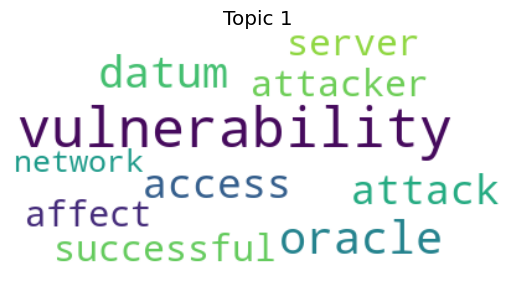

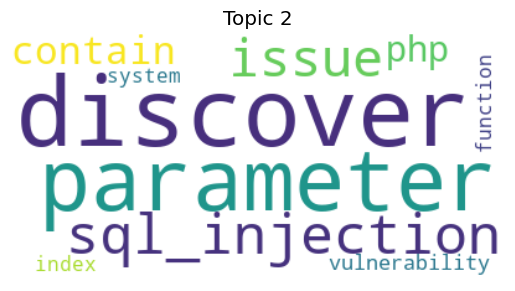

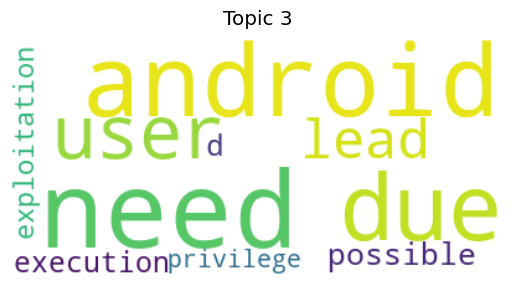

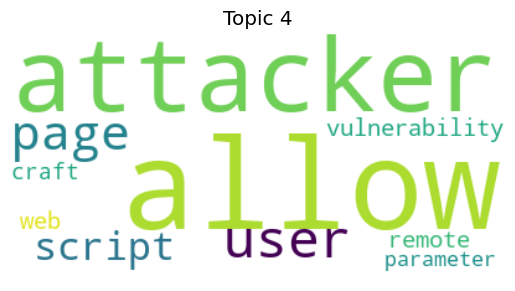

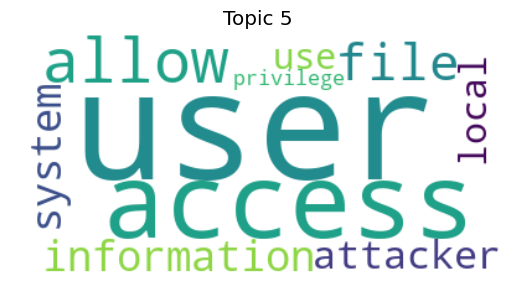

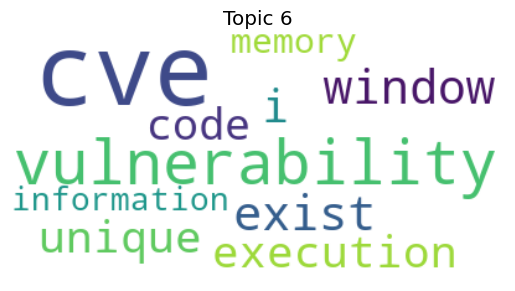

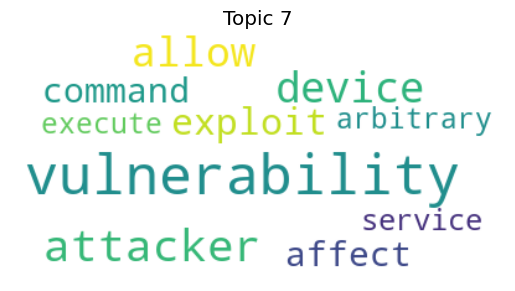

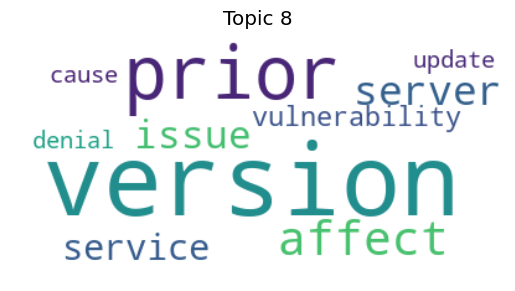

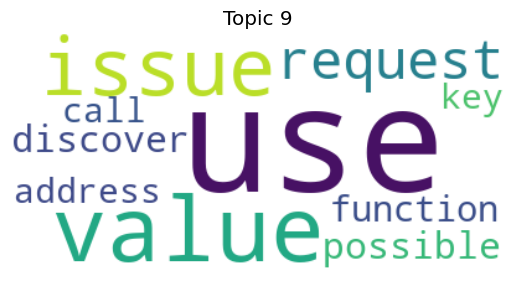

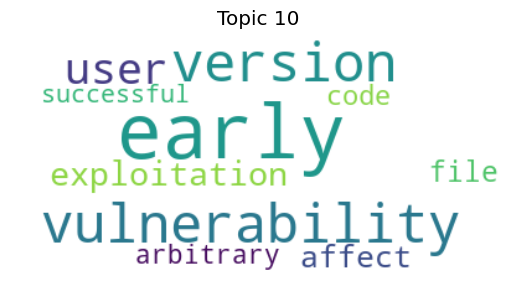

In [173]:
for i in range(0,ideal_topic_num-1):
    create_wordcloud(LDA_models[ideal_topic_num], topic=i+1)

# LDA Performance on Test Data

## Build Corpus

In [68]:
#Tokenize Words
processed_df_test = tokenize_words(x_test)

#Remove Stopwords
no_stop_df_test = remove_stopwords(processed_df_test)

#Create Bag of Words
words_list_test = bag_of_words(no_stop_df_test)

#n-gram words
n_gram_words_test = n_grams(words_list_test)

#Lemmatize
lemmatized_words_test = lemmatize(n_gram_words_test)

<ipython-input-19-4bede7c3d975>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['Description'].apply(lambda row:gensim.utils.simple_preprocess(str(row), deacc=True))
<ipython-input-19-4bede7c3d975>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['tokens']


In [69]:
#id2word = Dictionary(lemmatized_words)

# Term Document Frequency
corpus_test = [id2word.doc2bow(word) for word in lemmatized_words_test]

## Score 

In [71]:
#Train Perplexity
perplexity= LDA_models[ideal_topic_num].log_perplexity(corpus)
print(perplexity)

#Test Perplexity
perplexity_test = LDA_models[ideal_topic_num].log_perplexity(corpus_test)
print(perplexity_test)

-7.028715519112318
-6.622485223516467


# Dynamic Topic Model

## Time Slice 

In [72]:
def extract_time_slice(df):
    grouped_df= (df.groupby(['Year']).count())
    time_slice = list(grouped_df['ID'])
    return time_slice

In [73]:
time_slice = extract_time_slice(sorted_df)
print(time_slice)

[12701, 16587, 19839, 14157]


## Build Corpus

In [74]:
#Tokenize Words
processed_df_dtm = tokenize_words(sorted_df)

#Remove Stopwords
no_stop_df_dtm = remove_stopwords(processed_df_dtm)

#Create Bag of Words
words_list_dtm = bag_of_words(no_stop_df_dtm)

#n-gram words
n_gram_words_dtm = n_grams(words_list_dtm)

#Lemmatize
lemmatized_words_dtm = lemmatize(n_gram_words_dtm)

In [75]:
#Dictionary
id2word_dtm = Dictionary(lemmatized_words_dtm)

# Term Document Frequency
corpus_dtm = [id2word_dtm.doc2bow(word) for word in lemmatized_words_dtm]

In [76]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus_dtm,
                                id2word=id2word_dtm,
                                time_slice = time_slice,
                                num_topics = ideal_topic_num)

C:\Users\AEUNDHATI\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lho

## Visualize Topics

In [104]:
ldaseq.print_topics(time=0)

[[('code', 0.17115891103922504),
  ('execution', 0.1140491936927415),
  ('issue', 0.04763149520769759),
  ('arbitrary', 0.039273321258022166),
  ('vulnerability', 0.038974354279095666),
  ('remote', 0.03526768919753401),
  ('memory', 0.03434071929740585),
  ('fix', 0.02528121956091488),
  ('lead', 0.025084181059656097),
  ('craft', 0.024487494987124957),
  ('corruption', 0.01679757532311528),
  ('execute', 0.016193663307726265),
  ('able', 0.014989863555136589),
  ('application', 0.014008675108261282),
  ('security', 0.01359652144081399),
  ('exist', 0.012511218053056255),
  ('issue_addressed_improve', 0.011978324321985779),
  ('window', 0.01155197442781267),
  ('malicious', 0.011196467234239728),
  ('bound', 0.01007309767620852)],
 [('file', 0.14099290382220978),
  ('early', 0.08537405628247771),
  ('vulnerability', 0.05113073952482202),
  ('version', 0.04584018324859002),
  ('user', 0.037398191262185666),
  ('attacker', 0.028582142492967717),
  ('arbitrary', 0.025329506887518383),
  

In [106]:
ldaseq.print_topics(time=3)

[[('code', 0.14341577881167938),
  ('execution', 0.1174446070197266),
  ('issue', 0.050869914218179005),
  ('arbitrary', 0.04117182332282253),
  ('remote', 0.03711816991833056),
  ('memory', 0.03452098732948383),
  ('vulnerability', 0.034253141435701365),
  ('craft', 0.026033310880694237),
  ('lead', 0.025987748596650234),
  ('fix', 0.02568031575781018),
  ('execute', 0.017475890467087585),
  ('corruption', 0.016836867853980995),
  ('able', 0.016320340555526752),
  ('security', 0.015309823856173042),
  ('issue_addressed_improve', 0.015074006947736394),
  ('application', 0.0149571500343644),
  ('exist', 0.012550444433834471),
  ('malicious', 0.012045257059453637),
  ('window', 0.01140708829203931),
  ('bound', 0.01079407929442626)],
 [('file', 0.1451160128579939),
  ('early', 0.08132073809068933),
  ('vulnerability', 0.052548764724960194),
  ('version', 0.0445074285523508),
  ('user', 0.0389061251281983),
  ('attacker', 0.02963700360620215),
  ('arbitrary', 0.025593380379867164),
  ('ex

In [79]:
ldaseq.save('ldaseq_model_bigdata')

In [80]:
topic_vector = ldaseq[corpus_dtm[1]]
topic_vector

array([0.00066181, 0.2731069 , 0.46083617, 0.00066181, 0.08278506,
       0.17863918, 0.00066181, 0.00066181, 0.00066181, 0.00066181,
       0.00066181])

## Visualize DTM

In [81]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=0, corpus=corpus_dtm)

In [82]:
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

# Model Performance

# Ensemble LDA

In [83]:
from gensim.models import EnsembleLda

# Ensemble LDA model with 5 LDA models and 16 topics each
elda = EnsembleLda(corpus=corpus, id2word=id2word, num_topics=ideal_topic_num, num_models=5)

# Print topics if any
try:
  elda.print_topics()
except ValueError:
  print("The ensemble could not find stable topics!")

In [84]:
from pprint import pprint

In [85]:
pprint(elda.print_topics())

[(0,
  '0.027*"vulnerability" + 0.027*"allow" + 0.024*"user" + 0.021*"attacker" + '
  '0.017*"version" + 0.012*"file" + 0.010*"arbitrary" + 0.010*"issue" + '
  '0.009*"access" + 0.009*"code"'),
 (1,
  '0.039*"version" + 0.024*"vulnerability" + 0.017*"allow" + 0.016*"use" + '
  '0.015*"attacker" + 0.012*"code" + 0.012*"user" + 0.012*"prior" + '
  '0.011*"access" + 0.009*"server"')]


# CVSS Predictions

In [86]:
topic_pred_df = sorted_df.copy()
topic_pred_df.head()

,ID,Assigner,Description,Severity,Score,Timestamp,Date,Year,is_rejected,tokens,no_stopwords
0,CVE-2019-3494,cve@mitre.org,Simply-Blog through 2019-01-01 has SQL Injecti...,HIGH,7.5,2019-01-01T15:29Z,2019-01-01,2019,0,"[simply, blog, through, has, sql, injection, v...","[simply, blog, sql, injection, admin, php, del..."
1,CVE-2019-3500,cve@mitre.org,"aria2c in aria2 1.33.1, when --log is used, ca...",HIGH,7.8,2019-01-02T07:29Z,2019-01-02,2019,0,"[aria, in, aria, when, log, is, used, can, sto...","[aria, aria, log, used, store, basic, authenti..."
2,CVE-2019-3501,cve@mitre.org,The OUGC Awards plugin before 1.8.19 for MyBB ...,MEDIUM,4.8,2019-01-02T13:29Z,2019-01-02,2019,0,"[the, ougc, awards, plugin, before, for, mybb,...","[ougc, awards, plugin, mybb, allows, xss, craf..."
3,CVE-2019-3572,cve@mitre.org,An issue was discovered in libming 0.4.8. Ther...,MEDIUM,6.5,2019-01-02T15:29Z,2019-01-02,2019,0,"[an, issue, was, discovered, in, libming, ther...","[issue, discovered, libming, heap, based, buff..."
4,CVE-2019-3573,cve@mitre.org,"In libsixel v1.8.2, there is an infinite loop ...",MEDIUM,5.5,2019-01-02T15:29Z,2019-01-02,2019,0,"[in, libsixel, there, is, an, infinite, loop, ...","[libsixel, infinite, loop, function, file, fro..."


In [87]:
ideal_topic_num

11

In [88]:
def extract_topic_proportions(model,corpus,ideal_topic_num):
    
    columns_list = []
    for num in range(1,ideal_topic_num+1):
        columns_list.append('t{}'.format(num))
    
    df = pd.DataFrame(columns = columns_list)
    
    for i in range(len(corpus)):
        df.loc[len(df)] = ldaseq[corpus[i]].tolist()
    
    return df

In [89]:
topics_df = extract_topic_proportions(ldaseq,corpus_dtm,ideal_topic_num)
topics_df

C:\Users\AEUNDHATI\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))


,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11
0,0.003215,0.003215,0.269995,0.003215,0.003215,0.003215,0.003215,0.003215,0.003215,0.003215,0.701066
1,0.000662,0.273107,0.460836,0.000662,0.082785,0.178639,0.000662,0.000662,0.000662,0.000662,0.000662
2,0.000763,0.000763,0.769279,0.000763,0.000763,0.000763,0.000763,0.000763,0.000763,0.000763,0.223856
3,0.000474,0.000474,0.000474,0.942387,0.000474,0.000474,0.000474,0.000474,0.053349,0.000474,0.000474
4,0.003215,0.395274,0.003215,0.575787,0.003215,0.003215,0.003215,0.003215,0.003215,0.003215,0.003215
...,...,...,...,...,...,...,...,...,...,...,...
63279,0.208499,0.000826,0.000826,0.000826,0.000826,0.000826,0.000826,0.000826,0.000826,0.200049,0.584845
63280,0.001098,0.001098,0.580956,0.001098,0.001098,0.001098,0.001098,0.001098,0.001098,0.001098,0.409165
63281,0.000523,0.000523,0.000523,0.239183,0.000523,0.289153,0.000523,0.216062,0.000523,0.251939,0.000523
63282,0.001098,0.001098,0.001098,0.708356,0.001098,0.001098,0.001098,0.001098,0.001098,0.281765,0.001098


## Linear Regression

In [90]:
X = topics_df
y = topic_pred_df['Score']

In [91]:
import sklearn

In [92]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0, train_size = .75)

In [93]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [94]:
y_pred = regr.predict(X_test)

In [95]:
regr.intercept_

-890592484792.7919

In [96]:
regr.coef_

array([8.90592485e+11, 8.90592485e+11, 8.90592485e+11, 8.90592485e+11,
       8.90592485e+11, 8.90592485e+11, 8.90592485e+11, 8.90592485e+11,
       8.90592485e+11, 8.90592485e+11, 8.90592485e+11])

In [97]:
R2 = sklearn.metrics.r2_score(y_test,y_pred)
R2

0.06885499779114168

In [181]:
R2 = sklearn.metrics.r2_score(X_train, y_train)
R2

ValueError: y_true and y_pred have different number of output (11!=1)

In [ ]:
from statsmodels.stats.stattools import durbin_watson

durbinWatson = durbin_watson(topics_df['residual'])

print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')

In [ ]:
corr_mat=topics_df.corr().round(2)
mat_mask = np.triu(np.ones_like(corr_mat,dtype=bool))
sns.heatmap(corr_mat,mask=mat_mask)
plt.show()

In [ ]:
plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(X, y_pred, color='k', label='Regression model')
ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('Gas production (Mcf/day)', fontsize=14)
ax.set_xlabel('Porosity (%)', fontsize=14)
ax.text(0.8, 0.1, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
         transform=ax.transAxes, color='grey', alpha=0.5)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('$R^2= %.2f$' % r2, fontsize=18)

fig.tight_layout()

In [ ]:
import yellowbrick
from yellowbrick.regressor import PredictionError, ResidualsPlot
visualizer = PredictionError(regr)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

In [98]:
 #Grid Search with CV - LASSO Case

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso


# S1. Define grid of parameter. 


param_lasso = {'alpha' :  [0.000001,0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,100],
               'max_iter' : [1000,1500,2000,2500], 
               'fit_intercept':[False, True],
               'positive': [True,False]}

# S2. Define estimator:  

grid_lasso = Lasso()

# S3. Define GridSearchCV Estimation function, then train the model


grid_lasso_est = GridSearchCV(grid_lasso, param_lasso, cv = 20)

grid_lasso_est.fit(X_train, y_train)

grid_lasso_est.best_params_, grid_lasso_est.best_score_ # not unbiased measure

grid_lasso_est.score(X_test, y_test) # unbiased measure

C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2474.103532293593, tolerance: 12.7026132819978
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2461.4562021129386, tolerance: 12.698174470580417
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2418.9624649752805, tolerance: 12.685594676306847
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530

C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2538.359172736178, tolerance: 12.698159514770431
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2481.023489701023, tolerance: 12.67706525429146
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2525.960156069763, tolerance: 12.680499624329128
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530:

C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2527.4554174698133, tolerance: 12.680751121667823
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2533.4616424848937, tolerance: 12.706753695187386
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2536.2531791493675, tolerance: 12.719361847882029
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:

C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2539.940198497643, tolerance: 12.707464509758246
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2528.2166202069056, tolerance: 12.693698669971107
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2519.878052137341, tolerance: 12.682372498314479
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:53

0.06885643837509237

In [99]:
grid_lasso_est.best_params_

{'alpha': 1e-05, 'fit_intercept': True, 'max_iter': 1500, 'positive': False}

In [100]:
grid_lasso_est.best_estimator_.coef_

array([ 1.52709128e+00,  3.82809100e-02, -5.41468829e-02,  3.40793621e-01,
       -3.13962658e-01, -3.19920288e-01,  1.24899409e-01, -8.09650201e-01,
        8.47482629e-01,  1.15280533e-03, -6.37703879e-01])

In [101]:
grid_lasso_est.fit(X_train, y_train)

C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2474.103532293593, tolerance: 12.7026132819978
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2461.4562021129386, tolerance: 12.698174470580417
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2418.9624649752805, tolerance: 12.685594676306847
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530

C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2538.359172736178, tolerance: 12.698159514770431
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2481.023489701023, tolerance: 12.67706525429146
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2525.960156069763, tolerance: 12.680499624329128
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530:

C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2527.4554174698133, tolerance: 12.680751121667823
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2533.4616424848937, tolerance: 12.706753695187386
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2536.2531791493675, tolerance: 12.719361847882029
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:

C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2528.2166202069056, tolerance: 12.693698669971107
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2519.878052137341, tolerance: 12.682372498314479
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2532.031954357444, tolerance: 12.657848878443126
  model = cd_fast.enet_coordinate_descent(
C:\Users\AEUNDHATI\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:53

GridSearchCV(cv=20, estimator=Lasso(),
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100],
                         'fit_intercept': [False, True],
                         'max_iter': [1000, 1500, 2000, 2500],
                         'positive': [True, False]})

In [180]:
print('R squared training set', round(grid_lasso_est.score(X_train, y_train)*100, 2))
print('R squared test set', round(grid_lasso_est.score(X_test, y_test)*100, 2))

R squared training set 6.86
R squared test set 6.89


In [179]:
print('R squared training set', round(regr.score(X_train, y_train)*100, 2))
print('R squared test set', round(regr.score(X_test, y_test)*100, 2))

R squared training set 6.86
R squared test set 6.89


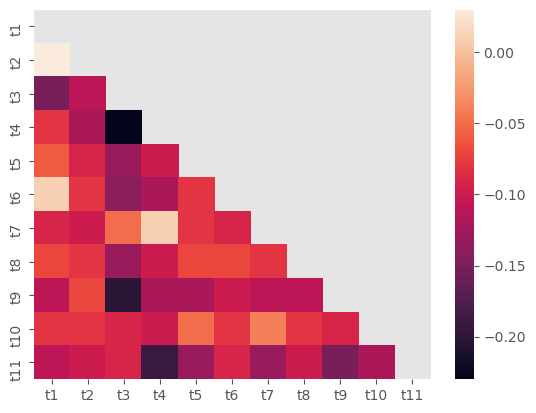

In [183]:
corr_mat=topics_df.corr().round(2)
mat_mask = np.triu(np.ones_like(corr_mat,dtype=bool))
sns.heatmap(corr_mat,mask=mat_mask)
plt.show()